In [1]:
!pip install pmdarima --user

In [2]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np



In [3]:
!pip install alpha_vantage

In [4]:


import math
import numpy as np 
import pandas as pd 
import time
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
# from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
import keras
import tensorflow
from datetime import date, timedelta, datetime
# This function adds plotting functions for calender dates
from pandas.plotting import register_matplotlib_converters
# Important package for visualization - we use this to plot the market data
import matplotlib.pyplot as plt 
# Formatting dates
import matplotlib.dates as mdates
# Packages for measuring model performance / errors
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Deep learning library, used for neural networks
from keras.models import Sequential 
# Deep learning classes for recurrent and regular densely-connected layers
from keras.layers import LSTM, Dense, Dropout
# EarlyStopping during model training
from keras.callbacks import EarlyStopping
# This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
from sklearn.preprocessing import RobustScaler
#new
import requests


In [5]:
# EXTRACTING INFO FOR TARGET STOCK
key='DUQG7U14LK4C3BT2'
# key = "5Y3MCR5FPN0GYZGO"
apiKey = key
t = 'AAPL'
ticker = t

df_temp = pd.read_csv('https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol='+ticker+'&apikey='+apiKey+'&outputsize=full&datatype=csv') 
ma5 = pd.read_csv('https://www.alphavantage.co/query?function=EMA&symbol='+ticker+'&interval=daily&time_period=5&series_type=close&apikey='+apiKey+'&datatype=csv')
ma30 = pd.read_csv('https://www.alphavantage.co/query?function=EMA&symbol='+ticker+'&interval=daily&time_period=30&series_type=close&apikey='+apiKey+'&datatype=csv')
ma180 = pd.read_csv('https://www.alphavantage.co/query?function=EMA&symbol='+ticker+'&interval=daily&time_period=180&series_type=close&apikey='+apiKey+'&datatype=csv')
atr = pd.read_csv('https://www.alphavantage.co/query?function=ATR&symbol='+ticker+'&interval=daily&time_period=14&apikey='+apiKey+'&datatype=csv&outputsize=full')

ma5 = ma5.truncate( after = 2564)
ma30 = ma30.truncate( after = 2564)
ma180= ma180.truncate( after = 2564)
df_temp = df_temp.truncate( after = 2564)
atr = atr.truncate(after = 2564)
df = df_temp.copy()
df['atr'] = atr['ATR']
df['ma5'] = ma5['EMA']
df['ma30'] = ma30['EMA']
df['ma180'] = ma180['EMA']
#now df has 10 columns with diff daily feature data for the past 2 years
#new
#time.sleep(50)
apiKey = "5Y3MCR5FPN0GYZGO"
rsi = pd.read_csv('https://www.alphavantage.co/query?function=RSI&symbol='+ticker+'&interval=daily&time_period=14&series_type=open&apikey='+apiKey+'&datatype=csv')
rsi['time'][0] = rsi['time'][0].split()[0]
obv = pd.read_csv('https://www.alphavantage.co/query?function=OBV&symbol='+ticker+'&interval=daily&apikey='+apiKey+'&datatype=csv')
obv['time'][0] = obv['time'][0].split()[0]
macd = pd.read_csv('https://www.alphavantage.co/query?function=MACD&symbol='+ticker+'&interval=daily&series_type=open&apikey='+apiKey+'&datatype=csv')
url = 'https://www.alphavantage.co/query?function=EARNINGS&symbol='+ticker+'&apikey='+apiKey
r = requests.get(url)
data = r.json()
eps_list = data['quarterlyEarnings']
eps = pd.DataFrame(columns=['date', 'eps'])
for i in range(len(eps_list)):
    eps.loc[i] = [eps_list[i]['reportedDate'],eps_list[i]['reportedEPS']]
if len(ma180)>=2565 : 
    rsi = rsi.truncate(after = 2564)
    obv = obv.truncate(after = 2564)
    macd = macd.truncate(after = 2564)
    eps = eps.truncate(after = 2564)
else:
    rsi = rsi.truncate(after = len(ma180)+1)
    obv = obv.truncate(after = len(ma180)+1)
    macd = macd.truncate(after = len(ma180)+1)
    eps = eps.truncate(after = len(ma180)+1)     

df['rsi'] = rsi['RSI']
df['obv'] =  obv['OBV']
df['macd'] = macd['MACD_Hist']
df.set_index('timestamp',drop = True, inplace = True)
eps.set_index('date',drop = True, inplace = True)
df['eps'] = eps['eps']
df.reset_index(inplace =True)
eps.reset_index(inplace  = True)
row = 0

for i in range(len(df)):
    if(pd.isnull(df['eps'][i])):
        df['eps'][i] = eps['eps'][row]
    else:
        row = row+1 
    
#now df has 14 columns with diff daily feature data for the past 2 years
temp=pd.DataFrame()
temp['time']=df['timestamp']
# temp['senti']=np.nan
temp['prev']=np.nan
index_eps=0
# print(eps['eps'][1])
for i in range(len(df)-1):
    # temp['senti'][i]=0.9996781
    temp['prev'][i]=df['close'][i+1]
# df['eps']=temp['eps']
# df['senti']=temp['senti']
df['prev']=temp['prev']
df = df[:-1]

train_dfs = df.copy()
train_dfs  = train_dfs.iloc[::-1]
train_dfs = train_dfs.set_index('timestamp')


#transform date indexes
date_index_fin = train_dfs.index
# Adding Month and Year in separate columns
d = pd.to_datetime(train_dfs.index)
train_dfs['Month'] = d.strftime("%m") 
train_dfs['Year'] = d.strftime("%Y") 
train_dfs = train_dfs.reset_index(drop=True).copy()


FEATURES = ['high', 'low', 'open', 'close', 'volume', 'Month', 'Year','atr','ma5','ma30','ma180', 'rsi', 'obv', 'macd', 'eps','prev']
# print('FEATURE LIST')
# print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pd.DataFrame(train_dfs)
data_filtered = data[FEATURES]
data_filtered_fin = data_filtered.copy()
# data_fin = data.copy()
# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['close'] 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to b

In [7]:
data

,open,high,low,close,volume,atr,ma5,ma30,ma180,rsi,obv,macd,eps,prev,Month,Year
0,347.86,349.20,346.5276,347.60,7312400,0.1728,10.6712,10.5846,9.8242,52.6733,9.242967e+10,0.0165,0.2275,346.66,05,2011
1,348.89,349.69,346.6600,349.45,10074700,0.1671,10.6910,10.5940,9.8342,53.7425,9.271176e+10,0.0131,0.2275,347.60,05,2011
2,349.02,350.00,345.2400,347.23,12000000,0.1656,10.6815,10.5984,9.8433,53.8841,9.237576e+10,0.0101,0.2275,349.45,05,2011
3,346.12,347.12,342.2700,346.57,11500000,0.1647,10.6684,10.6012,9.8522,50.1927,9.205376e+10,0.0016,0.2275,347.23,05,2011
4,345.66,346.25,340.3500,340.50,11647000,0.1665,10.5975,10.5918,9.8588,49.6121,9.172764e+10,-0.0050,0.2275,346.57,05,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2559,142.75,145.65,142.6522,145.11,99890800,2.3751,142.7643,134.4483,124.2918,74.9501,9.486302e+10,0.9529,1.4,143.24,07,2021
2560,146.21,146.32,144.0000,144.50,76299719,2.3711,143.3429,135.0968,124.5151,79.1187,9.478672e+10,1.0771,1.4,145.11,07,2021
2561,144.03,147.46,143.6300,145.64,100827099,2.4754,144.1086,135.7770,124.7485,71.0915,9.488755e+10,0.9325,1.4,144.50,07,2021
2562,148.10,149.57,147.6800,149.15,127050785,2.5793,145.7891,136.6397,125.0181,75.9894,9.501460e+10,1.0237,1.4,145.64,07,2021


In [8]:

#SCALING
# Calculate the number of rows in the data
nrows = data_filtered.shape[0]
np_data_unscaled = np.array(data_filtered)
np_data_unscaled = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data_unscaled.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = RobustScaler()
np_data = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = RobustScaler()
df_Close = pd.DataFrame(data_filtered_ext['close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

#SPLITTING
#Settings
sequence_length = 100

# Split the training data into x_train and y_train data sets
# Get the number of rows to train the model on 80% of the data 
train_data_len_fin = math.ceil(np_data.shape[0] * 0.8) #2616

# Create the training data
train_data = np_data[0:train_data_len_fin, :]
x_train, y_train = [], []

# The RNN needs data with the format of [samples, time steps, features].
# Here, we create N samples, 100 time steps per sample, and 2 features
for i in range(100, train_data_len_fin):
    x_train.append(train_data[i-sequence_length:i,:]) #contains 100 values 0-100 * columsn
    y_train.append(train_data[i, 0]) #contains the prediction values for validation
    
# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Create the test data
test_data = np_data[train_data_len_fin - sequence_length:, :]

# Split the test data into x_test and y_test
x_test, y_test = [], []
test_data_len = test_data.shape[0]
for i in range(sequence_length, test_data_len):
    x_test.append(test_data[i-sequence_length:i,:]) #contains 100 values 0-100 * columns
    y_test.append(test_data[i, 0]) #contains the prediction values for validation
# Convert the x_train and y_train to numpy arrays
x_test, y_test = np.array(x_test), np.array(y_test)

# Convert the x_train and y_train to numpy arrays
x_test_fin = np.array(x_test); y_test = np.array(y_test)
print(x_train.shape, y_train.shape)
print(x_test_fin.shape, y_test.shape)




(2564, 16)
(1952, 100, 16) (1952,)
(512, 100, 16) (512,)


In [9]:

model = Sequential()

n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=False, 
               input_shape=(x_train.shape[1], x_train.shape[2]))) 
# model.add(Dropout(0.2))
model.add(Dense(1, activation='relu'))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
epochs = 12
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history = model.fit(x_train, y_train, batch_size=16, 
                    epochs=epochs, callbacks=[early_stop])


1600 100 16
Epoch 1/12
122/122 [==============================] - 25s 63ms/step - loss: 0.1352
Epoch 2/12
122/122 [==============================] - 8s 63ms/step - loss: 0.0279
Epoch 3/12
122/122 [==============================] - 8s 64ms/step - loss: 0.0274
Epoch 4/12
122/122 [==============================] - 8s 65ms/step - loss: 0.0271
Epoch 5/12
122/122 [==============================] - 8s 67ms/step - loss: 0.0292
Epoch 6/12
122/122 [==============================] - 8s 69ms/step - loss: 0.0236
Epoch 7/12
122/122 [==============================] - 8s 70ms/step - loss: 0.0273
Epoch 8/12
122/122 [==============================] - 8s 68ms/step - loss: 0.0294
Epoch 00008: early stopping


In [10]:
#

# time.sleep(50)
epochs =8
# fin_stocks = ['EA','TSLA','AAPL']
fin_stocks = [
              'V', 
              # 'GM',
              'MA', 'EA', 'AAPL']
for ticker in fin_stocks:
    apiKey = "MBZEYCLG2CZBR3BG"
    df_temp = pd.read_csv('https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol='+ticker+'&apikey='+apiKey+'&outputsize=full&datatype=csv') 
    ma5 = pd.read_csv('https://www.alphavantage.co/query?function=EMA&symbol='+ticker+'&interval=daily&time_period=5&series_type=close&apikey='+apiKey+'&datatype=csv')
    ma30 = pd.read_csv('https://www.alphavantage.co/query?function=EMA&symbol='+ticker+'&interval=daily&time_period=30&series_type=close&apikey='+apiKey+'&datatype=csv')
    ma180 = pd.read_csv('https://www.alphavantage.co/query?function=EMA&symbol='+ticker+'&interval=daily&time_period=180&series_type=close&apikey='+apiKey+'&datatype=csv')
    atr = pd.read_csv('https://www.alphavantage.co/query?function=ATR&symbol='+ticker+'&interval=daily&time_period=14&apikey='+apiKey+'&datatype=csv&outputsize=full')
    
    ma5 = ma5.truncate( after = 2564)
    ma30 = ma30.truncate( after = 2564)
    ma180= ma180.truncate( after = 2564)
    df_temp = df_temp.truncate( after = 2564)
    atr = atr.truncate(after = 2564)
    df = df_temp.copy()
    df['atr'] = atr['ATR']
    df['ma5'] = ma5['EMA']
    df['ma30'] = ma30['EMA']
    df['ma180'] = ma180['EMA']
    #now df has 10 columns with diff daily feature data for the past 2 years
    
    #new
    # time.sleep(60)
    apiKey = "5Y3MCR5FPN0GYZGO"
    rsi = pd.read_csv('https://www.alphavantage.co/query?function=RSI&symbol='+ticker+'&interval=daily&time_period=14&series_type=open&apikey='+apiKey+'&datatype=csv')
    rsi['time'][0] = rsi['time'][0].split()[0]
    obv = pd.read_csv('https://www.alphavantage.co/query?function=OBV&symbol='+ticker+'&interval=daily&apikey='+apiKey+'&datatype=csv')
    obv['time'][0] = obv['time'][0].split()[0]
    macd = pd.read_csv('https://www.alphavantage.co/query?function=MACD&symbol='+ticker+'&interval=daily&series_type=open&apikey='+apiKey+'&datatype=csv')
    url = 'https://www.alphavantage.co/query?function=EARNINGS&symbol='+ticker+'&apikey='+apiKey
    r = requests.get(url)
    data = r.json()
    eps_list = data['quarterlyEarnings']
    eps = pd.DataFrame(columns=['date', 'eps'])
    for i in range(len(eps_list)):
        eps.loc[i] = [eps_list[i]['reportedDate'],eps_list[i]['reportedEPS']]
    if len(ma180)>=2565 : 
        rsi = rsi.truncate(after = 2564)
        obv = obv.truncate(after = 2564)
        macd = macd.truncate(after = 2564)
        eps = eps.truncate(after = 2564)
    else:
        rsi = rsi.truncate(after = len(ma180)+1)
        obv = obv.truncate(after = len(ma180)+1)
        macd = macd.truncate(after = len(ma180)+1)
        eps = eps.truncate(after = len(ma180)+1)     
    
    df['rsi'] = rsi['RSI']
    df['obv'] =  obv['OBV']
    df['macd'] = macd['MACD_Hist']
    df.set_index('timestamp',drop = True, inplace = True)
    eps.set_index('date',drop = True, inplace = True)
    df['eps'] = eps['eps']
    df.reset_index(inplace =True)
    eps.reset_index(inplace  = True)
    row = 0
    
    for i in range(len(df)):
        if(pd.isnull(df['eps'][i])):
            df['eps'][i] = eps['eps'][row]
        else:
            row = row+1 
     
    temp=pd.DataFrame()
    temp['time']=df['timestamp']
    # temp['senti']=np.nan
    temp['prev']=np.nan
    index_eps=0
    # print(eps['eps'][1])
    
    for i in range(len(df)-1):
        # if ticker=='TSLA':
            # temp['senti'][i]= 0.9997481
        # if ticker=='AAPL':
            # temp['senti'][i]= 0.9996781
        # if ticker=='EA':
            # temp['senti'][i]= 0.9999581   
        temp['prev'][i]=df['close'][i+1]
    # df['senti']=temp['senti']
    df['prev']=temp['prev']
    df = df[:-1]
    
    
    train_dfs = df.copy()
    train_dfs  = train_dfs.iloc[::-1]
    train_dfs = train_dfs.set_index('timestamp')
    
    
    #transform date indexes
    date_index = train_dfs.index
    # Adding Month and Year in separate columns
    d = pd.to_datetime(train_dfs.index)
    train_dfs['Month'] = d.strftime("%m") 
    train_dfs['Year'] = d.strftime("%Y") 
    train_dfs = train_dfs.reset_index(drop=True).copy()
    
    
    # List of considered Features
    #FEATURES = ['high', 'low', 'open', 'close', 'volume', 'Month', 'Year','atr','ma5','ma30','ma180','']
    FEATURES = ['high', 'low', 'open', 'close', 'volume', 'Month', 'Year','atr','ma5','ma30','ma180', 'rsi', 'obv', 'macd', 'eps','prev']

    # print('FEATURE LIST')
    # print([f for f in FEATURES])
    
    # Create the dataset with features and filter the data to the list of FEATURES
    data = pd.DataFrame(train_dfs)
    data_filtered = data[FEATURES]
    print(ticker)
    print(data_filtered.head())
    # We add a prediction column and set dummy values to prepare the data for scaling
    data_filtered_ext = data_filtered.copy()
    data_filtered_ext['Prediction'] = data_filtered_ext['close'] 
    
    #SCALING
    # Calculate the number of rows in the data
    nrows = data_filtered.shape[0]
    np_data_unscaled = np.array(data_filtered)
    np_data_unscaled = np.reshape(np_data_unscaled, (nrows, -1))
    print(np_data_unscaled.shape)
    
    # Transform the data by scaling each feature to a range between 0 and 1
    scaler = RobustScaler()
    np_data = scaler.fit_transform(np_data_unscaled)
    
    # Creating a separate scaler that works on a single column for scaling predictions
    scaler_pred = RobustScaler()
    df_Close = pd.DataFrame(data_filtered_ext['close'])
    np_Close_scaled = scaler_pred.fit_transform(df_Close)
    
    #SPLITTING
    #Settings
    sequence_length = 100
    
    # Split the training data into x_train and y_train data sets
    # Get the number of rows to train the model on 80% of the data 
    train_data_len = math.ceil(np_data.shape[0] * 0.8) #2616
    
    # Create the training data
    train_data = np_data[0:train_data_len, :]
    x_train, y_train = [], []
    
    # The RNN needs data with the format of [samples, time steps, features].
    # Here, we create N samples, 100 time steps per sample, and 2 features
    for i in range(100, train_data_len):
        x_train.append(train_data[i-sequence_length:i,:]) #contains 100 values 0-100 * columsn
        y_train.append(train_data[i, 0]) #contains the prediction values for validation
        
    # Convert the x_train and y_train to numpy arrays
    x_train, y_train = np.array(x_train), np.array(y_train)
    
    # Create the test data
    test_data = np_data[train_data_len - sequence_length:, :]
    
    # Split the test data into x_test and y_test
    x_test, y_test = [], []
    test_data_len = test_data.shape[0]
    for i in range(sequence_length, test_data_len):
        x_test.append(test_data[i-sequence_length:i,:]) #contains 100 values 0-100 * columns
        y_test.append(test_data[i, 0]) #contains the prediction values for validation
    # Convert the x_train and y_train to numpy arrays
    x_test, y_test = np.array(x_test), np.array(y_test)
    
    # Convert the x_train and y_train to numpy arrays
    x_test = np.array(x_test); y_test = np.array(y_test)
        
    print(x_train.shape, y_train.shape)
    print(x_test.shape, y_test.shape)
    
    
    early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
    history = model.fit(x_train, y_train, batch_size=16, 
                    epochs=epochs, callbacks=[early_stop])



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to b

V
    high    low   open  close  ...           obv    macd   eps   prev
0  79.98  79.04  79.13  79.86  ...  1.540010e+09  0.0016  0.31  79.41
1  80.70  79.72  79.97  80.35  ...  1.559716e+09  0.0077  0.31  79.86
2  80.25  78.95  80.22  79.34  ...  1.542049e+09  0.0122  0.31  80.35
3  80.05  79.08  79.09  79.93  ...  1.567127e+09 -0.0048  0.31  79.34
4  80.18  79.70  80.00  79.91  ...  1.545653e+09 -0.0043  0.31  79.93

[5 rows x 16 columns]
(2564, 16)
(1952, 100, 16) (1952,)
(512, 100, 16) (512,)
Epoch 1/8
122/122 [==============================] - 8s 65ms/step - loss: 0.1279
Epoch 2/8
122/122 [==============================] - 8s 66ms/step - loss: 0.1279
Epoch 3/8
122/122 [==============================] - 8s 68ms/step - loss: 0.1278
Epoch 4/8
122/122 [==============================] - 9s 70ms/step - loss: 0.1279
Epoch 5/8
122/122 [==============================] - 8s 69ms/step - loss: 0.1280
Epoch 00005: early stopping


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to b

MA
     high     low    open   close  ...           obv    macd   eps    prev
0  279.29  273.11  274.52  278.77  ...  1.435261e+09 -0.0371  0.43  274.25
1  281.64  278.89  279.99  281.10  ...  1.440509e+09 -0.0303  0.43  278.77
2  282.00  277.06  281.00  278.13  ...  1.433755e+09 -0.0235  0.43  281.10
3  282.75  276.70  277.07  282.10  ...  1.440995e+09 -0.0467  0.43  278.13
4  282.74  279.46  282.27  280.00  ...  1.435161e+09 -0.0322  0.43  282.10

[5 rows x 16 columns]
(2564, 16)
(1952, 100, 16) (1952,)
(512, 100, 16) (512,)
Epoch 1/8
122/122 [==============================] - 8s 64ms/step - loss: 0.1309
Epoch 2/8
122/122 [==============================] - 8s 66ms/step - loss: 0.1306
Epoch 3/8
122/122 [==============================] - 8s 68ms/step - loss: 0.1312
Epoch 4/8
122/122 [==============================] - 9s 70ms/step - loss: 0.1312
Epoch 00004: early stopping


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to b

EA
     high      low   open  close  ...         obv    macd    eps   prev
0  22.230  21.6900  21.75  22.04  ... -91806550.0  0.1031  -0.37  21.75
1  22.875  21.9712  22.09  22.76  ... -84400850.0  0.1438  -0.37  22.04
2  22.980  22.3300  22.65  22.61  ... -90000850.0  0.1939  -0.37  22.76
3  23.090  22.4400  22.60  22.88  ... -85800850.0  0.2080  -0.37  22.61
4  24.050  22.9200  22.92  23.70  ... -75129550.0  0.2219  -0.37  22.88

[5 rows x 16 columns]
(2564, 16)
(1952, 100, 16) (1952,)
(512, 100, 16) (512,)
Epoch 1/8
122/122 [==============================] - 8s 66ms/step - loss: 0.1729
Epoch 2/8
122/122 [==============================] - 8s 68ms/step - loss: 0.1748
Epoch 3/8
122/122 [==============================] - 9s 70ms/step - loss: 0.1726
Epoch 4/8
122/122 [==============================] - 8s 69ms/step - loss: 0.1723
Epoch 5/8
122/122 [==============================] - 8s 67ms/step - loss: 0.1723
Epoch 6/8
122/122 [==============================] - 8s 66ms/step - loss: 0.1724

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to b

AAPL
     high       low    open   close  ...           obv    macd     eps    prev
0  349.20  346.5276  347.86  347.60  ...  9.242967e+10  0.0165  0.2275  346.66
1  349.69  346.6600  348.89  349.45  ...  9.271176e+10  0.0131  0.2275  347.60
2  350.00  345.2400  349.02  347.23  ...  9.237576e+10  0.0101  0.2275  349.45
3  347.12  342.2700  346.12  346.57  ...  9.205376e+10  0.0016  0.2275  347.23
4  346.25  340.3500  345.66  340.50  ...  9.172764e+10 -0.0050  0.2275  346.57

[5 rows x 16 columns]
(2564, 16)
(1952, 100, 16) (1952,)
(512, 100, 16) (512,)
Epoch 1/8
122/122 [==============================] - 8s 65ms/step - loss: 0.0276
Epoch 2/8
122/122 [==============================] - 8s 67ms/step - loss: 0.0265
Epoch 3/8
122/122 [==============================] - 8s 69ms/step - loss: 0.0265
Epoch 4/8
122/122 [==============================] - 9s 71ms/step - loss: 0.0260
Epoch 5/8
122/122 [==============================] - 8s 69ms/step - loss: 0.0279
Epoch 6/8
122/122 [=================

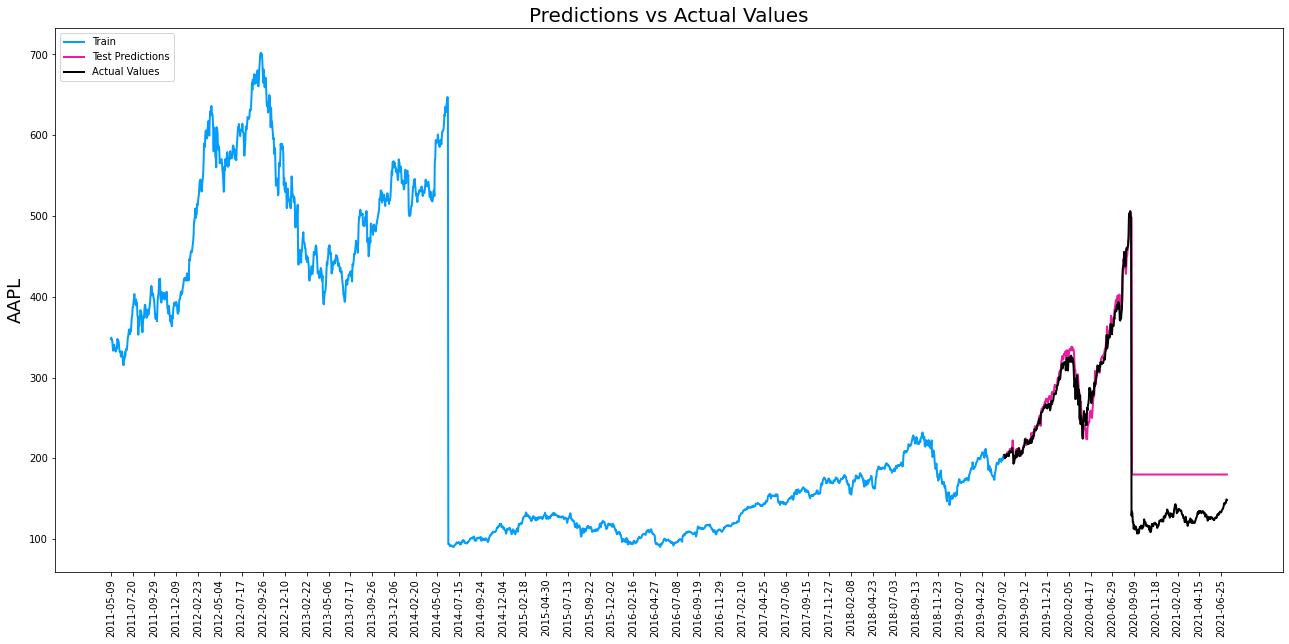

In [11]:
# Get the predicted values-+*/
predictions = model.predict(x_test_fin)
 
# Get the predicted values
pred_unscaled = scaler_pred.inverse_transform(predictions)


# Add the date column
data_filtered_sub = data_filtered_fin.copy()
data_filtered_sub['Date'] = date_index_fin

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len_fin + 1]
valid = data_filtered_sub[train_data_len_fin:]
valid.insert(1, "Prediction", pred_unscaled.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["close"], True)
#------------------------------------------------------------


# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["close"]]
xv = valid['Date']; yv = valid[["close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.ylabel(ticker, fontsize=18)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["close"], color="black", linewidth=2.0)
plt.xticks( rotation ='vertical')
size = len(yt) + len(yv)
plt.xticks(np.arange(0,size,50))
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")


In [12]:


MAPE = np.mean((np.abs(valid['Difference']/ valid['close']))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(valid['Difference']/ valid['close'])) ) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')


Mean Absolute Percentage Error (MAPE): 20.99 %
Median Absolute Percentage Error (MDAPE): 6.39 %


In [13]:
old_df= df.copy()
df= valid.copy()
df.rename(columns={"Difference":"residue"},inplace = True)
df.rename(columns={"Date":"timestamp"},inplace = True)

In [14]:
df.drop(['prev'],axis = 1, inplace= True)

In [15]:
df.reset_index(drop=True, inplace=True)
lag_features = ["high", "low", "volume", "atr","rsi","obv","macd",
                #"prev"
               ]
window1 = 3
window2 = 7
window3 = 30

df_rolled_3d = df[lag_features].rolling(window=window1, min_periods=0)
df_rolled_7d = df[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = df[lag_features].rolling(window=window3, min_periods=0)

df_mean_3d = df_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index().astype(np.float32)

df_std_3d = df_rolled_3d.std().shift(1).reset_index().astype(np.float32)
df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float32)
df_std_30d = df_rolled_30d.std().shift(1).reset_index().astype(np.float32)

for feature in lag_features:
    df[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
    df[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
    df[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]
    
    df[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
    df[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
    df[f"{feature}_std_lag{window3}"] = df_std_30d[feature]

df.fillna(df.mean(), inplace=True)



In [16]:
df.set_index("timestamp", drop=False, inplace=True)
df.head()

,high,residue,Prediction,low,open,close,volume,Month,Year,atr,ma5,ma30,ma180,rsi,obv,macd,eps,timestamp,high_mean_lag3,high_mean_lag7,high_mean_lag30,high_std_lag3,high_std_lag7,high_std_lag30,low_mean_lag3,low_mean_lag7,low_mean_lag30,low_std_lag3,low_std_lag7,low_std_lag30,volume_mean_lag3,volume_mean_lag7,volume_mean_lag30,volume_std_lag3,volume_std_lag7,volume_std_lag30,atr_mean_lag3,atr_mean_lag7,atr_mean_lag30,atr_std_lag3,atr_std_lag7,atr_std_lag30,rsi_mean_lag3,rsi_mean_lag7,rsi_mean_lag30,rsi_std_lag3,rsi_std_lag7,rsi_std_lag30,obv_mean_lag3,obv_mean_lag7,obv_mean_lag30,obv_std_lag3,obv_std_lag7,obv_std_lag30,macd_mean_lag3,macd_mean_lag7,macd_mean_lag30,macd_std_lag3,macd_std_lag7,macd_std_lag30
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-07-05,205.08,-0.336781,203.893219,202.90,203.35,204.23,17265518,07,2019,0.8944,49.7236,48.0314,46.0586,64.5634,9.211127e+10,0.1583,0.62,2019-07-05,222.252884,222.475662,224.005188,3.602647,6.362312,17.737915,216.996140,217.220184,218.739349,3.701062,6.501852,17.782064,67611144.0,67310912.0,65965192.0,13537587.0,17026504.0,22129618.0,2.552294,2.546474,2.516580,0.065873,0.115501,0.305821,58.608196,58.548347,58.402885,3.040866,4.260693,7.271761,9.372330e+10,9.371251e+10,9.365820e+10,99726928.0,133802736.0,277992704.0,0.019924,0.016346,0.000969,0.115532,0.212730,0.469910
2019-07-08,201.40,4.427006,204.447006,198.41,200.81,200.02,25338628,07,2019,0.9325,49.5105,48.0994,46.0920,58.6979,9.200992e+10,0.0920,0.62,2019-07-08,205.080002,205.080002,205.080002,3.602647,6.362312,17.737915,202.899994,202.899994,202.899994,3.701062,6.501852,17.782064,17265518.0,17265518.0,17265518.0,13537587.0,17026504.0,22129618.0,0.894400,0.894400,0.894400,0.065873,0.115501,0.305821,64.563400,64.563400,64.563400,3.040866,4.260693,7.271761,9.211127e+10,9.211127e+10,9.211127e+10,99726928.0,133802736.0,277992704.0,0.158300,0.158300,0.158300,0.115532,0.212730,0.469910
2019-07-09,201.51,-0.167612,201.072388,198.81,199.20,201.24,20578015,07,2019,0.9132,49.4682,48.1822,46.1284,55.2703,9.209223e+10,0.0136,0.62,2019-07-09,203.240005,203.240005,203.240005,2.602153,2.602153,2.602153,200.654999,200.654999,200.654999,3.174909,3.174909,3.174909,21302072.0,21302072.0,21302072.0,5708551.0,5708551.0,5708551.0,0.913450,0.913450,0.913450,0.026941,0.026941,0.026941,61.630650,61.630650,61.630650,4.147535,4.147535,4.147535,9.206060e+10,9.206060e+10,9.206060e+10,71668464.0,71668464.0,71668464.0,0.125150,0.125150,0.125150,0.046881,0.046881,0.046881
2019-07-10,203.73,-1.697102,201.532898,201.56,201.85,203.23,17897138,07,2019,0.8917,49.6028,48.2912,46.1697,59.4659,9.216382e+10,-0.0015,0.62,2019-07-10,202.663330,202.663330,202.663330,2.093617,2.093617,2.093617,200.039993,200.039993,200.039993,2.484894,2.484894,2.484894,21060720.0,21060720.0,21060720.0,4058143.5,4058143.5,4058143.5,0.913367,0.913367,0.913367,0.019051,0.019051,0.019051,59.510532,59.510532,59.510532,4.699543,4.699543,4.699543,9.207114e+10,9.207114e+10,9.207114e+10,53868092.0,53868092.0,53868092.0,0.087967,0.087967,0.087967,0.072434,0.072434,0.072434
2019-07-11,204.39,3.025208,204.775208,201.71,203.31,201.75,20191842,07,2019,0.8749,49.5714,48.3698,46.2066,61.6028,9.208305e+10,0.0051,0.62,2019-07-11,202.213333,202.929993,202.929993,1.314623,1.790698,1.790698,199.593338,200.419998,200.419998,1.714886,2.166579,2.166579,21271260.0,20269824.0,20269824.0,3768870.5,3671659.5,3671659.5,0.912467,0.907950,0.907950,0.020410,0.018955,0.018955,57.811367,59.499374,59.499374,2.233880,3.837226,3.837226,9.208866e+10,9.209431e+10,9.209431e+10,77012544.0,63889252.0,63889252.0,0.034700,0.065600,0.065600,0.050194,0.074154,0.074154


In [17]:
df.timestamp = pd.to_datetime(df.timestamp, format="%Y-%m-%d")
df["month"] = df.timestamp.dt.month
df["week"] = df.timestamp.dt.week
df["day"] = df.timestamp.dt.day
df["day_of_week"] = df.timestamp.dt.dayofweek
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,high,residue,Prediction,low,open,close,volume,Month,Year,atr,ma5,ma30,ma180,rsi,obv,macd,eps,timestamp,high_mean_lag3,high_mean_lag7,high_mean_lag30,high_std_lag3,high_std_lag7,high_std_lag30,low_mean_lag3,low_mean_lag7,low_mean_lag30,low_std_lag3,low_std_lag7,low_std_lag30,volume_mean_lag3,volume_mean_lag7,volume_mean_lag30,volume_std_lag3,volume_std_lag7,volume_std_lag30,atr_mean_lag3,atr_mean_lag7,atr_mean_lag30,atr_std_lag3,atr_std_lag7,atr_std_lag30,rsi_mean_lag3,rsi_mean_lag7,rsi_mean_lag30,rsi_std_lag3,rsi_std_lag7,rsi_std_lag30,obv_mean_lag3,obv_mean_lag7,obv_mean_lag30,obv_std_lag3,obv_std_lag7,obv_std_lag30,macd_mean_lag3,macd_mean_lag7,macd_mean_lag30,macd_std_lag3,macd_std_lag7,macd_std_lag30,month,week,day,day_of_week
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-07-05,205.08,-0.336781,203.893219,202.90,203.35,204.23,17265518,07,2019,0.8944,49.7236,48.0314,46.0586,64.5634,9.211127e+10,0.1583,0.62,2019-07-05,222.252884,222.475662,224.005188,3.602647,6.362312,17.737915,216.996140,217.220184,218.739349,3.701062,6.501852,17.782064,67611144.0,67310912.0,65965192.0,13537587.0,17026504.0,22129618.0,2.552294,2.546474,2.516580,0.065873,0.115501,0.305821,58.608196,58.548347,58.402885,3.040866,4.260693,7.271761,9.372330e+10,9.371251e+10,9.365820e+10,99726928.0,133802736.0,277992704.0,0.019924,0.016346,0.000969,0.115532,0.212730,0.469910,7,27,5,4
2019-07-08,201.40,4.427006,204.447006,198.41,200.81,200.02,25338628,07,2019,0.9325,49.5105,48.0994,46.0920,58.6979,9.200992e+10,0.0920,0.62,2019-07-08,205.080002,205.080002,205.080002,3.602647,6.362312,17.737915,202.899994,202.899994,202.899994,3.701062,6.501852,17.782064,17265518.0,17265518.0,17265518.0,13537587.0,17026504.0,22129618.0,0.894400,0.894400,0.894400,0.065873,0.115501,0.305821,64.563400,64.563400,64.563400,3.040866,4.260693,7.271761,9.211127e+10,9.211127e+10,9.211127e+10,99726928.0,133802736.0,277992704.0,0.158300,0.158300,0.158300,0.115532,0.212730,0.469910,7,28,8,0
2019-07-09,201.51,-0.167612,201.072388,198.81,199.20,201.24,20578015,07,2019,0.9132,49.4682,48.1822,46.1284,55.2703,9.209223e+10,0.0136,0.62,2019-07-09,203.240005,203.240005,203.240005,2.602153,2.602153,2.602153,200.654999,200.654999,200.654999,3.174909,3.174909,3.174909,21302072.0,21302072.0,21302072.0,5708551.0,5708551.0,5708551.0,0.913450,0.913450,0.913450,0.026941,0.026941,0.026941,61.630650,61.630650,61.630650,4.147535,4.147535,4.147535,9.206060e+10,9.206060e+10,9.206060e+10,71668464.0,71668464.0,71668464.0,0.125150,0.125150,0.125150,0.046881,0.046881,0.046881,7,28,9,1
2019-07-10,203.73,-1.697102,201.532898,201.56,201.85,203.23,17897138,07,2019,0.8917,49.6028,48.2912,46.1697,59.4659,9.216382e+10,-0.0015,0.62,2019-07-10,202.663330,202.663330,202.663330,2.093617,2.093617,2.093617,200.039993,200.039993,200.039993,2.484894,2.484894,2.484894,21060720.0,21060720.0,21060720.0,4058143.5,4058143.5,4058143.5,0.913367,0.913367,0.913367,0.019051,0.019051,0.019051,59.510532,59.510532,59.510532,4.699543,4.699543,4.699543,9.207114e+10,9.207114e+10,9.207114e+10,53868092.0,53868092.0,53868092.0,0.087967,0.087967,0.087967,0.072434,0.072434,0.072434,7,28,10,2
2019-07-11,204.39,3.025208,204.775208,201.71,203.31,201.75,20191842,07,2019,0.8749,49.5714,48.3698,46.2066,61.6028,9.208305e+10,0.0051,0.62,2019-07-11,202.213333,202.929993,202.929993,1.314623,1.790698,1.790698,199.593338,200.419998,200.419998,1.714886,2.166579,2.166579,21271260.0,20269824.0,20269824.0,3768870.5,3671659.5,3671659.5,0.912467,0.907950,0.907950,0.020410,0.018955,0.018955,57.811367,59.499374,59.499374,2.233880,3.837226,3.837226,9.208866e+10,9.209431e+10,9.209431e+10,77012544.0,63889252.0,63889252.0,0.034700,0.065600,0.065600,0.050194,0.074154,0.074154,7,28,11,3


In [18]:
df_train = df[df.timestamp < "2021"]
df_valid = df[df.timestamp >= "2021"]

# len_predict = len(df[df.timestamp >= "2021"])


In [19]:
exogenous_features = ["high_mean_lag3", "high_std_lag3", "low_mean_lag3", "low_std_lag3",
                      "volume_mean_lag3", "volume_std_lag3", "atr_mean_lag3",
                    "atr_std_lag3",
                     "rsi_mean_lag3",
                      "rsi_std_lag3","obv_mean_lag3",
                      "obv_std_lag3","macd_mean_lag3",
                      "macd_std_lag3",
                      #"prev_mean_lag3","prev_std_lag3",
                      "high_mean_lag7", "high_std_lag7", "low_mean_lag7", "low_std_lag7",
                      "volume_mean_lag7", "volume_std_lag7", "atr_mean_lag7",
                      "atr_std_lag7",
                      "rsi_mean_lag7", 
                      "rsi_std_lag7","obv_mean_lag7", "obv_std_lag7",
                      "macd_mean_lag7", "macd_std_lag7",
                      #"prev_mean_lag7","prev_std_lag7",
                      "high_mean_lag30", "high_std_lag30", "low_mean_lag30", "low_std_lag30",
                      "volume_mean_lag30", "volume_std_lag30", "atr_mean_lag30",
                      "atr_std_lag30",
                      "rsi_mean_lag30", "rsi_std_lag30","obv_mean_lag30", "obv_std_lag30",
                      "macd_mean_lag30", "macd_std_lag30",
                      #"prev_mean_lag30","prev_std_lag30",
                      "month", "week", "day", "day_of_week"]

In [20]:
model = auto_arima(df_train.close,exogenous=df_train[exogenous_features],  trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_train["residue"],exogenous=df_train[exogenous_features])

forecast = model.predict(n_periods=len(df_valid),exogenous=df_valid[exogenous_features])
df_valid["Forecast_ARIMAX"] = forecast

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=3407.762, Time=3.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=3414.900, Time=1.71 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3408.457, Time=1.78 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=3406.095, Time=2.48 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5279.290, Time=1.62 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=3404.778, Time=2.60 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=3406.247, Time=2.50 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=3406.197, Time=3.08 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=3404.216, Time=2.65 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=3406.331, Time=2.99 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=3408.098, Time=3.29 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=3402.209, Time=2.76 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3404.093, Time=2.55 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=3404.186, Time=2.89 sec
 ARIMA(0,0,3)(0,0,0)[0]          

/root/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [21]:
# df_valid['final_pred'] = df_valid['residue']+ df_valid['close']
df_valid['final_pred'] = df_valid['Prediction']-df_valid['Forecast_ARIMAX']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


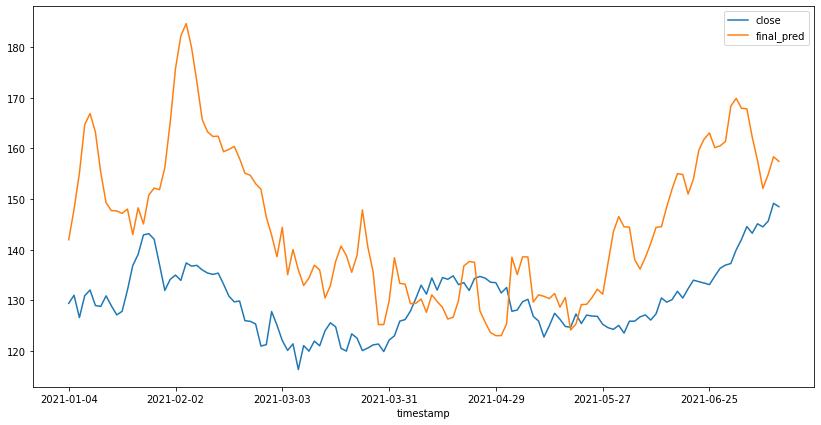

In [22]:
df_valid[["close", "final_pred"]].plot(figsize=(14, 7))
#plot for timestamp>2021 only

In [23]:
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.close, df_valid.final_pred)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid.close, df_valid.final_pred))

RMSE of Auto ARIMAX: 19.310221934692326

MAE of Auto ARIMAX: 16.120028892825797


In [24]:
mape = np.mean(np.abs(df_valid.final_pred - df_valid.close)/np.abs(df_valid.close))
print('MAPE: '+str(mape*100) + ' %')
mdape = np.median(np.abs(df_valid.final_pred - df_valid.close)/np.abs(df_valid.close))
print('MDAPE: '+str(mdape*100) + ' %')

MAPE: 12.380047354790175 %
MDAPE: 11.960794402898575 %


In [25]:
old_df

,timestamp,open,high,low,close,volume,atr,ma5,ma30,ma180,rsi,obv,macd,eps,prev
0,2021-07-15,149.24,150.00,147.0900,148.48,106820297,2.6029,146.6860,137.4036,125.2774,77.1568,9.490778e+10,1.0685,1.4,149.15
1,2021-07-14,148.10,149.57,147.6800,149.15,127050785,2.5793,145.7891,136.6397,125.0181,75.9894,9.501460e+10,1.0237,1.4,145.64
2,2021-07-13,144.03,147.46,143.6300,145.64,100827099,2.4754,144.1086,135.7770,124.7485,71.0915,9.488755e+10,0.9325,1.4,144.50
3,2021-07-12,146.21,146.32,144.0000,144.50,76299719,2.3711,143.3429,135.0968,124.5151,79.1187,9.478672e+10,1.0771,1.4,145.11
4,2021-07-09,142.75,145.65,142.6522,145.11,99890800,2.3751,142.7643,134.4483,124.2918,74.9501,9.486302e+10,0.9529,1.4,143.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2559,2011-05-13,345.66,346.25,340.3500,340.50,11647000,0.1665,10.5975,10.5918,9.8588,49.6121,9.172764e+10,-0.0050,0.2275,346.57
2560,2011-05-12,346.12,347.12,342.2700,346.57,11500000,0.1647,10.6684,10.6012,9.8522,50.1927,9.205376e+10,0.0016,0.2275,347.23
2561,2011-05-11,349.02,350.00,345.2400,347.23,12000000,0.1656,10.6815,10.5984,9.8433,53.8841,9.237576e+10,0.0101,0.2275,349.45
2562,2011-05-10,348.89,349.69,346.6600,349.45,10074700,0.1671,10.6910,10.5940,9.8342,53.7425,9.271176e+10,0.0131,0.2275,347.60


In [26]:
old_df =  df[df.timestamp < "2021"]

In [27]:
df_valid

,high,residue,Prediction,low,open,close,volume,Month,Year,atr,ma5,ma30,ma180,rsi,obv,macd,eps,timestamp,high_mean_lag3,high_mean_lag7,high_mean_lag30,high_std_lag3,high_std_lag7,high_std_lag30,low_mean_lag3,low_mean_lag7,low_mean_lag30,low_std_lag3,low_std_lag7,low_std_lag30,volume_mean_lag3,volume_mean_lag7,volume_mean_lag30,volume_std_lag3,volume_std_lag7,volume_std_lag30,atr_mean_lag3,atr_mean_lag7,atr_mean_lag30,atr_std_lag3,atr_std_lag7,atr_std_lag30,rsi_mean_lag3,rsi_mean_lag7,rsi_mean_lag30,rsi_std_lag3,rsi_std_lag7,rsi_std_lag30,obv_mean_lag3,obv_mean_lag7,obv_mean_lag30,obv_std_lag3,obv_std_lag7,obv_std_lag30,macd_mean_lag3,macd_mean_lag7,macd_mean_lag30,macd_std_lag3,macd_std_lag7,macd_std_lag30,month,week,day,day_of_week,Forecast_ARIMAX,final_pred
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-04,133.6116,50.565006,179.975006,126.7600,133.52,129.41,143301887,01,2021,3.5544,131.4927,125.9978,106.4764,61.9074,9.503926e+10,0.4690,0.73,2021-01-04,136.506332,135.307709,125.856812,2.073295,2.219141,6.488084,133.153641,132.071564,123.088493,1.327705,1.711888,6.201271,105538680.0,107463752.0,102583784.0,13496793.00,35545300.0,34549940.0,3.336467,3.279986,3.143040,0.041090,0.082301,0.167474,67.417900,66.893883,59.233181,4.727698,2.947862,7.033292,9.528078e+10,9.534972e+10,9.518337e+10,97787384.0,100650304.0,198203648.0,0.898433,0.795186,0.407140,0.162846,0.142940,0.350930,1,1,4,0,38.020344,141.954662
2021-01-05,131.7400,48.965006,179.975006,128.4300,128.89,131.01,97664898,01,2021,3.5362,131.1929,126.2943,106.7429,52.5242,9.513692e+10,-0.0383,0.73,2021-01-05,134.780533,135.194366,126.316528,1.189718,2.291997,6.534036,130.626663,131.658707,123.380493,3.452381,2.540962,6.159507,112956864.0,103742328.0,104816440.0,26313306.00,28688282.0,34956128.0,3.393900,3.314528,3.145657,0.139452,0.133247,0.173364,63.882332,66.280968,59.506168,2.407895,3.509278,6.970492,9.516783e+10,9.529685e+10,9.518961e+10,121878520.0,149471312.0,190215584.0,0.710700,0.772100,0.407803,0.238564,0.181737,0.351031,1,1,5,1,32.012962,147.962044
2021-01-06,131.0499,53.375006,179.975006,126.3820,127.72,126.60,155087970,01,2021,3.6160,129.5277,126.2880,106.9579,50.4435,9.498183e+10,-0.4611,0.73,2021-01-06,133.363861,135.095795,126.739197,1.515265,2.440711,6.458121,128.970001,131.322983,123.767830,2.523708,2.816688,6.097121,113361120.0,105091072.0,105601504.0,25939618.00,28051970.0,34504348.0,3.464333,3.363500,3.150603,0.140533,0.143879,0.182393,59.202168,64.233086,59.535446,5.817909,6.237621,6.938105,9.511958e+10,9.527054e+10,9.519662e+10,73208152.0,160307904.0,183953376.0,0.382600,0.659943,0.396750,0.385040,0.357357,0.359870,1,1,6,2,24.900234,155.074772
2021-01-07,131.6300,49.055006,179.975006,127.8600,128.36,130.92,109578157,01,2021,3.7158,129.8530,126.5600,107.2181,51.5736,9.509141e+10,-0.6926,0.73,2021-01-07,132.133835,134.751495,127.148529,1.325483,2.846229,6.323356,127.190666,130.648987,124.070900,1.089808,3.385904,5.989035,132018248.0,119399344.0,108317632.0,30328908.00,23352210.0,35100700.0,3.568867,3.431029,3.162763,0.041821,0.133887,0.200585,54.958366,62.185856,59.429272,6.107301,8.103184,7.054999,9.505267e+10,9.521422e+10,9.520092e+10,78409312.0,184484880.0,177018016.0,-0.010133,0.493329,0.373320,0.465689,0.551753,0.391774,1,1,7,3,15.296654,164.678352
2021-01-08,132.6300,47.925006,179.975006,130.2300,132.43,132.05,105158245,01,2021,3.6213,130.4453,126.8871,107.4878,58.1149,9.519657e+10,-0.5724,0.73,2021-01-08,131.473297,133.935791,127.615517,0.370777,2.798565,6.109100,127.557335,129.841843,124.541229,1.057015,3.261358,5.697512,120777008.0,117464136.0,107704920.0,30305330.00,23552484.0,34905908.0,3.622667,3.490257,3.176807,0.089985,0.156651,0.223558,51.513767,59.814629,59.464191,1.041640,8.479329,7.011877,9.507005e+10,9.515597e+10,9.521313e+10,79719080.0,138045088.0,154209216.0,-0.397333,0.281757,0.346967,0.331778,0.687097,0.435124,1,1,8,4,13.115935,166.859071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

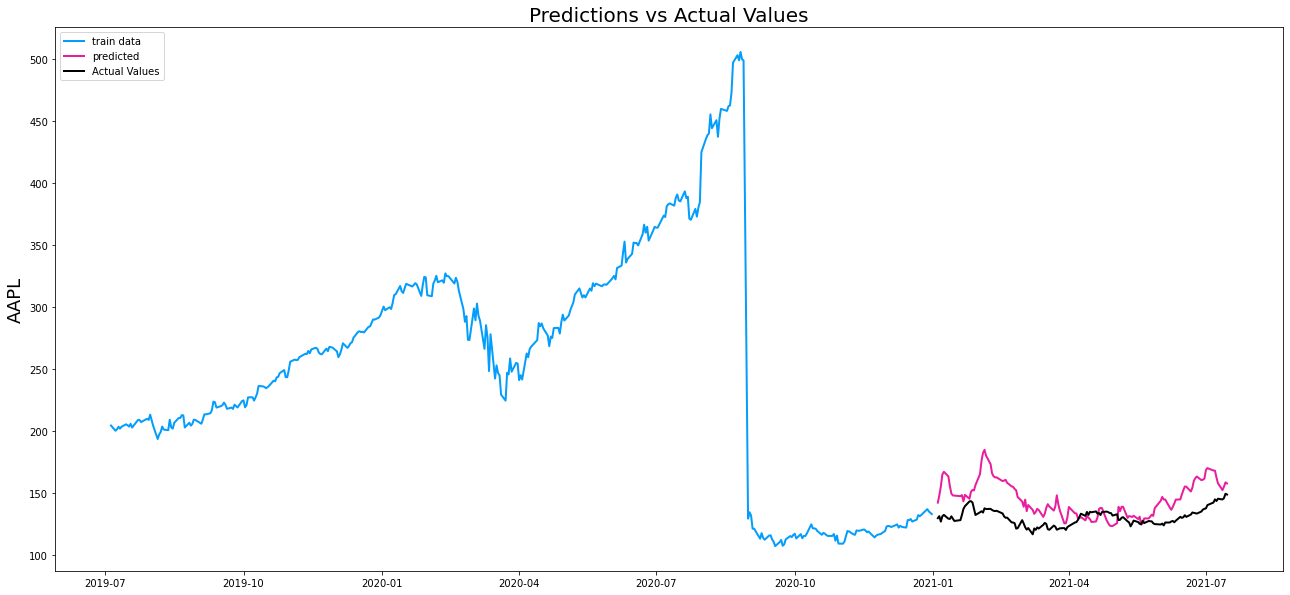

In [29]:


# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xo = old_df['timestamp']
yo = old_df[['close']]
# train['timestamp']=train['Date']
# valid['timestamp']=valid['Date']
# xt = train['Date']; yt = train[["close"]]
xv = df_valid['timestamp']; yv = df_valid[["close", "final_pred"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.ylabel(ticker, fontsize=18)
# plt.plot(xo, yo, color="yellow", linewidth=2.0)
# xt.xaxis_date() 
# xv.xaxis_date
plt.plot(xo, yo, color="#039dfc", linewidth=2.0)
# plt.plot(train.Date, yt, color="yellow", linewidth=2.0)
plt.plot(df_valid.timestamp, yv["final_pred"], color="#E91D9E", linewidth=2.0)
plt.plot(df_valid.timestamp, yv["close"], color="black", linewidth=2.0)
# plt.xticks( rotation ='vertical')
# size = len(yt) + len(yv)
# plt.xticks(np.arange(0,size,50))
plt.legend(["train data", "predicted", "Actual Values"], loc="upper left")